In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['animation.embed_limit'] = 2**128
from matplotlib import animation
from IPython.display import HTML

In [3]:
def normal_density_function(x, mean, standard_deviation):
    return np.exp(-(x - mean)**2 / (2 * standard_deviation**2)) / (standard_deviation * np.sqrt(2 * np.pi))

In [4]:
def initial_conditions(parameters):

    S0 = parameters['S0']
    R0 = parameters['R0']
    S0_distribution = parameters['S0_distribution']
    R0_distribution = parameters['R0_distribution']
    space_points = parameters['space_points']

    if S0_distribution == 'uniform':
        S = np.ones(space_points)
    elif S0_distribution == 'normal':
        space_start = parameters['space_start']
        space_end = parameters['space_end']
        X = np.linspace(space_start, space_end, space_points)
        standard_deviation_S = parameters['standard_deviation_S']
        mean = (space_end-space_start)/2
        # S is Gaussian distributed
        S = np.zeros(space_points)
        for i in range(space_points):
            S[i] = normal_density_function(X[i], mean, standard_deviation_S)
    elif S0_distribution == 'concentrated':
        S = np.zeros(space_points)
        S[space_points//2] = 1
        S[space_points//2 + 1] = 1
        S[space_points//2 - 1] = 1
    else:
        raise ValueError(
            'S0_distribution must be uniform or normal or concentrated')

    if R0_distribution == 'uniform':
        R = np.random.uniform(0, 1, space_points)
    elif R0_distribution == 'normal':
        space_start = parameters['space_start']
        space_end = parameters['space_end']
        X = np.linspace(space_start, space_end, space_points)
        standard_deviation_R = parameters['standard_deviation_R']
        mean = (space_end-space_start)/2
        # R is Gaussian distributed
        R = np.zeros(space_points)
        for i in range(space_points):
            R[i] = normal_density_function(X[i], mean, standard_deviation_R)
    elif R0_distribution == 'concentrated':
        R = np.zeros(space_points)
        R[space_points//2] = 1
        R[space_points//2 + 1] = 1
        R[space_points//2 - 1] = 1
    else:
        raise ValueError('R0_distribution must be uniform or normal')

    # rescale S and R to have the correct initial size
    S = S0 * S
    R = R0 * R
    N = S + R

    return S, R, N


In [5]:
def therapy_drug_concentration(S, R, parameters):

    N = np.trapz(S + R, dx=parameters['space_step'])

    therapy_type = parameters['therapy_type']
    maximum_tollerated_dose = parameters['maximum_tollerated_dose']

    if therapy_type == 'continuous':
        return maximum_tollerated_dose
    if therapy_type == 'notherapy':
        return 0
    elif therapy_type == 'adaptive':
        N0 = parameters['S0'] + parameters['R0']
        if N > 0.5 * N0:
            return maximum_tollerated_dose
        else:
            return 0
    else:
        raise ValueError(
            'therapy_type must be continuous, notherapy or adaptive')

In [6]:
def sign(X):
    if X > 0:
        return 1
    elif X < 0:
        return -1
    else:
        return 0


def compute_diffusion(S, R, parameters):

    diffusion_type = parameters['diffusion_type']

    if diffusion_type == 'standard':
        space_step = parameters['space_step']
        diffusion_coefficient_S = parameters['diffusion_coefficient_S']
        diffusion_coefficient_R = parameters['diffusion_coefficient_R']
        diffusion_S = diffusion_coefficient_S * \
            (S[0] - 2 * S[1] + S[2]) / space_step**2
        diffusion_R = diffusion_coefficient_R * \
            (R[0] - 2 * R[1] + R[2]) / space_step**2
        
        if diffusion_S > 100000:
            print(diffusion_S)

        return diffusion_S, diffusion_R

    elif diffusion_type == 'none':
        return 0, 0
    elif diffusion_type == 'special':

        space_step = parameters['space_step']
        carrying_capacity_S = parameters['carrying_capacity_S']
        carrying_capacity_R = parameters['carrying_capacity_R']
        diffusion_coefficient_S = parameters['diffusion_coefficient_S']
        diffusion_coefficient_R = parameters['diffusion_coefficient_R']
        effective_diffusion_coefficient_S = sign(S[1]) * diffusion_coefficient_S * \
            (S[1] / carrying_capacity_S - 1)
        effective_diffusion_coefficient_R = diffusion_coefficient_R * \
            (R[1] / carrying_capacity_R - 1)
        diffusion_S = effective_diffusion_coefficient_S * \
            (S[0] - 2 * S[1] + S[2]) / space_step**2
        diffusion_R = effective_diffusion_coefficient_R * \
            (R[0] - 2 * R[1] + R[2]) / space_step**2
        return diffusion_S, diffusion_R

    else:
        raise ValueError('diffusion_type must be standard, none or special')


In [7]:
def boundary_conditions(S_old, R_old, parameters):

    time_boundary_conditions = parameters['time_boundary_conditions']

    if time_boundary_conditions == 'Dirichlet':
        S_left = parameters['S0_left']
        R_left = parameters['R0_left']
        S_right = parameters['S0_right']
        R_right = parameters['R0_right']

    # Neumann boundary conditions read NSPDE on how to implement them
    elif time_boundary_conditions == 'Neumann':
        time_step = parameters['time_step']
        S_left = S_old[0]/2 + S_old[1]/2 + parameters['S0_left'] * time_step
        R_left = R_old[0]/2 + R_old[1]/2 + parameters['R0_left'] * time_step
        S_right = S_old[-1]/2 + S_old[-2]/2 + parameters['S0_right'] * time_step
        R_right = R_old[-1] + R_old[-2]/2 + parameters['R0_right'] * time_step

    else:
        raise ValueError(
            'time_boundary_conditions must be Dirichlet or Neumann')

    return S_left, R_left, S_right, R_right



In [8]:
def one_step(S_old, R_old, parameters):

    # initialize new arrays
    S = np.zeros(len(S_old))
    R = np.zeros(len(R_old))
    N = np.zeros(len(S_old))
    maximum_tollerated_dose = parameters['maximum_tollerated_dose']

    # boundary conditions
    S[0], R[0], S[-1], R[-1] = boundary_conditions(S_old, R_old, parameters)
    N[0] = S[0] + R[0]
    N[-1] = S[-1] + R[-1]

    # constants
    time_step = parameters['time_step']
    growth_rate_S = parameters['growth_rate_S']
    growth_rate_R = parameters['growth_rate_R']
    carrying_capacity = parameters['carrying_capacity']
    division_rate = parameters['division_rate']
    death_rate_S = parameters['death_rate_S']
    death_rate_R = parameters['death_rate_R']
    maximum_tollerated_dose = parameters['maximum_tollerated_dose']
    D = therapy_drug_concentration(
        S_old, R_old, parameters)/maximum_tollerated_dose

    for i in range(1, len(S_old)-1):

        current_carrying_capacity = (S_old[i] + R_old[i]) / carrying_capacity
        effective_growth_rate_S = growth_rate_S * \
            (1 - current_carrying_capacity) * (1 - 2 * division_rate * D)
        effective_growth_rate_R = growth_rate_R * \
            (1 - current_carrying_capacity)

        dS = effective_growth_rate_S - death_rate_S
        dR = effective_growth_rate_R - death_rate_R

        diffusion_S, diffusion_R = compute_diffusion(
            S_old[i-1:i+2], R_old[i-1:i+2], parameters)

        S[i] = S_old[i] + time_step * (dS * S_old[i] + diffusion_S)
        R[i] = R_old[i] + time_step * (dR * R_old[i] + diffusion_R)

    #
    tolerance = parameters['tolerance']
    #mask_S = S < tolerance
    #mask_R = R < tolerance
    #S[mask_S] = 0
    #R[mask_R] = 0

    return S, R, N, D


In [9]:
def pde_2D_model(parameters):

    time_start = parameters['time_start']
    time_end = parameters['time_end']
    time_points = parameters['time_points']
    parameters['time_step'] = (time_end - time_start) / time_points

    space_start = parameters['space_start']
    space_end = parameters['space_end']
    space_points = parameters['space_points']
    parameters['space_step'] = (space_end - space_start) / space_points

    X = np.linspace(space_start, space_end, space_points)
    T = np.linspace(time_start, time_end, time_points)

    S = np.ones((space_points, time_points))
    R = np.zeros((space_points, time_points))
    N = np.zeros((space_points, time_points))
    D = np.zeros(time_points)

    index = 0

    S[:, index], R[:, index], N[:, index] = initial_conditions(parameters)

    for t in T[1:]:
        S[:, index + 1], R[:, index + 1], N[:, index + 1], D[index +
                                                             1] = one_step(S[:, index], R[:, index], parameters)
        index += 1

    return S, R, N, D, X, T


In [16]:
parameters = {
    'time_start': 0,
    'time_end': 10,
    'time_points': 1000,
    'space_start': 0,
    'space_end': 1,
    'space_points': 100,
    'tolerance': 0.0000001,
    'S0': 0.4,
    'R0': 0.2,
    'S0_distribution': 'concentrated',
    'R0_distribution': 'concentrated',
    'growth_rate_S': 0,
    'growth_rate_R': 0.03,
    'carrying_capacity': 3,
    'diffusion_coefficient_S': 0.001,
    'diffusion_coefficient_R': 0.001,
    'maximum_tollerated_dose': 1,
    'death_rate_S': 0,
    'death_rate_R': 0,
    'division_rate': 20,
    'therapy_type': 'continuous',
    'time_boundary_conditions': 'Dirichlet',
    'S0_left': 0,
    'R0_left': 0,
    'S0_right': 0,
    'R0_right': 0,
    'diffusion_type': 'standard',
    'standard_deviation_S': 0.1,
    'standard_deviation_R': 0.1,
    'carrying_capacity_S': 1,
    'carrying_capacity_R': 1
}

S, R, N, D, X, T = pde_2D_model(parameters)

print(S[:, 0])
print(S[:, 5])
print(S[:, -1])

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.4 0.4 0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 4.00000e-06 1.64000e-04 2.74400e-03 2.38600e-02
 1.13340e-01 2

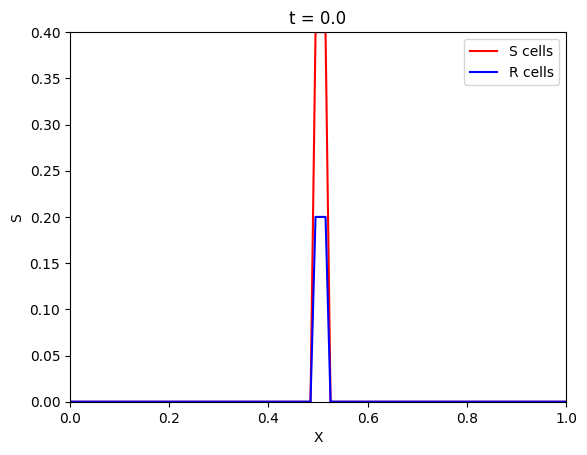

In [17]:
#save the file as an mp4 file
#requires ffmpeg

# plot the results
fig, ax = plt.subplots()
ax.set_xlabel('X')
ax.set_ylabel('S')
plotLineS, = ax.plot(X, np.zeros(len(X))*np.NaN, 'r-', label = 'S cells')
plotLineR, = ax.plot(X, np.zeros(len(X))*np.NaN, 'b-', label = 'R cells')
plotTitle = ax.set_title("t=0")
ax.set_ylim(0,(np.max([np.max(S),np.max(R)])))
ax.legend()
ax.set_xlim(parameters['space_start'], parameters['space_end'])
#ax.set_yscale('log')

def animate(t):
    pp = S[:, t]
    qq = R[:,t]
    plotLineS.set_ydata(pp)
    plotLineR.set_ydata(qq)
    plotTitle.set_text(f"t = {t:.1f}")
    # ax.relim() # use if autoscale desired
    # ax.autoscale()
    return [plotLineS, plotLineR, plotTitle]

ani = animation.FuncAnimation(
    fig, func=animate, frames=np.arange(0,len(T),1000), blit=True)

#to show animation in the notebook uncomment the below line 
HTML(ani.to_jshtml()) 

#to save the video uncomment the below
    #note the following line needs changing if ran on another machine
    #use path to ffmpeg file 
#plt.rcParams['animation.ffmpeg_path'] = "/Users/kyliesavoye/Desktop/ffmpeg-5.0.1-essentials_build/bin/ffmpeg"
#writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
#ani.save('anim.mp4', writer=writer) 
#plt.show()


#sharp fronts come from linear diffusion terms
#might want to model non linear diffusion otherwise we might have sharp fronts


#comparing ODE with PDE when do boundary effect come into play
#boundary play was little rile as possible - socilating boundary conditions 
#in real life -  zero flux i.e. neumann 
#in real life moving boundary problem 
#the cells reaching this boundary -  matastasis 
#have two sets of boundaries? the tumour and the healthy cells around the tumour 
#
#to copare ODE and PDE - zero flux boundary conditions give the same resyults? 
# normal and sensitive cells would be killed by the drug 
#use same division rate initially for all three types of cells - that would be the best unrealistic case for AT 
#in reality N cells would divide very slowly and decrease the efficacity of AT
#we want to check if ODE description is good description of the PDE - check spacial description and number of cancerous cells
#Murray - Kristen Swanson
#be careful with diffusion equation - maybe use the telegraph equation which gives finite solutions
#is the PDE a good description of the agent based model?
#is the ODE a good secription of a spacially distributed system?
#haptotaxis - movement up the gradient --> flux is: Cont * density * del(density)/del(x) 
#the solution to this over large amount of time gives the delta function 
#maybe balance it out with diffusion or we could argue that in reality there would be no blow up because cells have a volume 
#

### explore ode and try anf get cycles
#maybe get an ODE model and see how it compares with the PDE model using periodic boundary conditions
#if ABM working compare it with the ODE is it a good description or do we need a more complicated model with more complex diffusion 
#what should we use to model cell movement -  still an open model 
#check Haptotaxis 

In [44]:
print(np.max([np.max(S),np.max(R)]))


0.4


In [25]:
print(S[:, 1])
print(np.shape(S))
print(S)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.04 0.36 0.4  0.36 0.04 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]
(100, 1000)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.31093202e-05
  3.32654280e-05 3.34219107e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.77797186e-05
  6.80956830e-05 6.84123922e-05]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.48840619e-05
  8.52591390e-05 8.56350027e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.15142611e-05
  4.16998151e-05 4.1885766